In [14]:
# Análise Genérica de Dados de Criminalidade
# ------------------------------------------

# Importações
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from openpyxl import load_workbook
from IPython.display import display
from fpdf import FPDF

# Configurações de exibição
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [ ]:
# Função: Carregamento de dados xlsx
caminho_pasta = '../../dados_tratados/PNAD_2009/csv'

agressao = glob.glob(os.path.join(caminho_pasta, 'agressao/*.csv'), recursive=True)
furto = glob.glob(os.path.join(caminho_pasta, 'furto/*.csv'), recursive=True)
roubo = glob.glob(os.path.join(caminho_pasta, 'roubo/*.csv'), recursive=True)
roubofurto = glob.glob(os.path.join(caminho_pasta, 'roubofurto/*.csv'), recursive=True)
seguranca = glob.glob(os.path.join(caminho_pasta, 'seguranca/*.csv'), recursive=True)
tentativa = glob.glob(os.path.join(caminho_pasta, 'tentativa/*.csv'), recursive=True)


def carregar_dados(caminho):
    dados = {}

    for arquivo in caminho:
        try:

            nome_base = os.path.basename(arquivo)
            nome_df = nome_base.replace('.csv', '')

            dados[nome_df] = pd.read_csv(
                arquivo,
                sep=';',         # Separador de campos
                encoding='utf-8',  # Codificação do arquivo
                header=[0,1],      # A primeira linha é o cabeçalho
                #skiprows=1,  # Pular a segunda linha (se necessário)
                index_col=0,   # A primeira coluna é o índice
            )

            print(f"[OK] CSV '{nome_df}' carregado.")
        except Exception as e:
            print(f"[ERRO] Ao ler o arquivo CSV '{arquivo}': {e}")

    return dados

dados = {
    "agressao": carregar_dados(agressao),
    "furto": carregar_dados(furto),
    "roubo": carregar_dados(roubo),
    "roubofurto": carregar_dados(roubofurto),
    "seguranca": carregar_dados(seguranca),
    "tentativa": carregar_dados(tentativa)
}

"""
Gere visualizações de dados a partir dos arquivos CSV anexados sobre violência (`agressao.xlsx - *.csv`).

Cada arquivo é uma tabela onde a primeira coluna é a categoria principal. Priorize a análise e criação de gráficos que explorem as relações entre:

- Tipos de **agressão** (física, psicológica, etc.).
- Comparações por **sexo** (colunas 'Homens' e 'Mulheres').
- Distribuição por **cor/raça** (colunas 'Branca', 'Preta', 'Parda', etc.).
- Recortes por **faixa etária** ou **ciclo de vida**.
- O **local da ocorrência** da agressão.

Crie gráficos de barras, de pizza e comparativos que revelem os padrões mais significativos nesses cruzamentos de dados.
"""

[OK] CSV 'cv126011a' carregado.
[OK] CSV 'cv126012a' carregado.
[OK] CSV 'cv126013a' carregado.
[OK] CSV 'cv126021a' carregado.
[OK] CSV 'cv126022a' carregado.
[OK] CSV 'cv126023a' carregado.
[OK] CSV 'cv126031a' carregado.
[OK] CSV 'cv126032a' carregado.
[OK] CSV 'cv126033a' carregado.
[OK] CSV 'cv126041a' carregado.
[OK] CSV 'cv126042a' carregado.
[OK] CSV 'cv126051a' carregado.
[OK] CSV 'cv126052a' carregado.
[OK] CSV 'cv126061a' carregado.
[OK] CSV 'cv126062a' carregado.
[OK] CSV 'cv126071a' carregado.
[OK] CSV 'cv126072a' carregado.
[OK] CSV 'cv126081a' carregado.
[OK] CSV 'cv126082a' carregado.
[OK] CSV 'cv126091a' carregado.
[OK] CSV 'cv126092a' carregado.
[OK] CSV 'cv126101a' carregado.
[OK] CSV 'cv126102a' carregado.
[OK] CSV 'cv126111a' carregado.
[OK] CSV 'cv126112a' carregado.
[OK] CSV 'cv126121a' carregado.
[OK] CSV 'cv126122a' carregado.
[OK] CSV 'cv126131a' carregado.
[OK] CSV 'cv126132a' carregado.
[OK] CSV 'cv126133a' carregado.
[OK] CSV 'cv126141a' carregado.
[OK] CSV

"\nGere visualizações de dados a partir dos arquivos CSV anexados sobre violência (`agressao.xlsx - *.csv`).\n\nCada arquivo é uma tabela onde a primeira coluna é a categoria principal. Priorize a análise e criação de gráficos que explorem as relações entre:\n\n- Tipos de **agressão** (física, psicológica, etc.).\n- Comparações por **sexo** (colunas 'Homens' e 'Mulheres').\n- Distribuição por **cor/raça** (colunas 'Branca', 'Preta', 'Parda', etc.).\n- Recortes por **faixa etária** ou **ciclo de vida**.\n- O **local da ocorrência** da agressão.\n\nCrie gráficos de barras, de pizza e comparativos que revelem os padrões mais significativos nesses cruzamentos de dados.\n"

In [11]:
display(dados['agressao']['cv126011a'])

,total,homens,mulheres,branca,preta/parda
brasil,2.18,2.52,2.75,2.92,2.66
urbana,2.33,2.68,2.91,3.09,2.86
rural,7.28,8.16,9.43,10.66,8.11
norte,5.08,5.47,7.34,9.22,5.19
rondônia,15.48,21.57,12.42,21.66,15.79
acre,21.99,20.60,26.85,44.59,15.11
amazonas,12.95,12.82,21.71,27.60,14.52
roraima,16.55,24.38,24.40,23.16,22.53
pará,7.58,7.90,11.18,15.12,7.49
amapá,18.56,20.32,27.95,25.25,19.16



📊 Gerando gráficos para: cv126011a


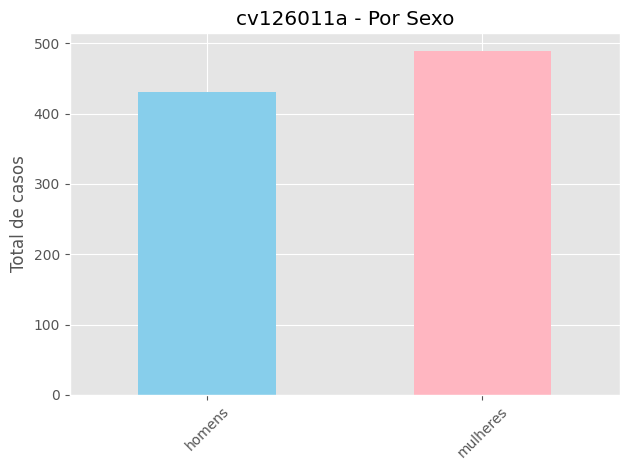

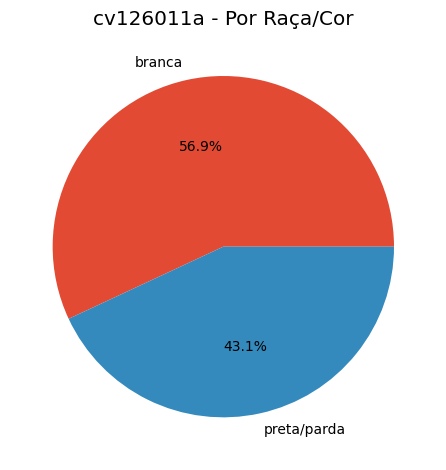


📊 Gerando gráficos para: cv126012a


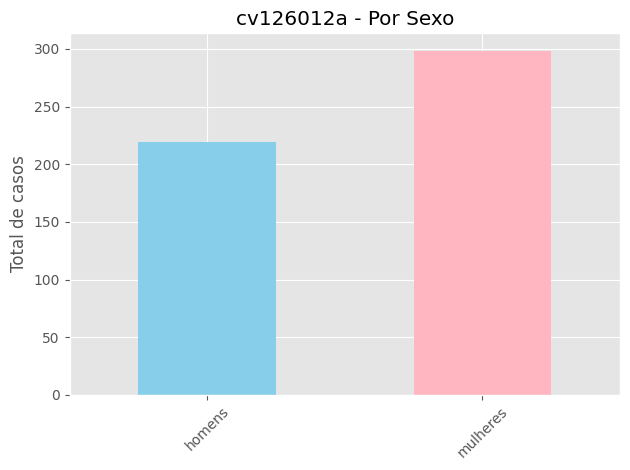

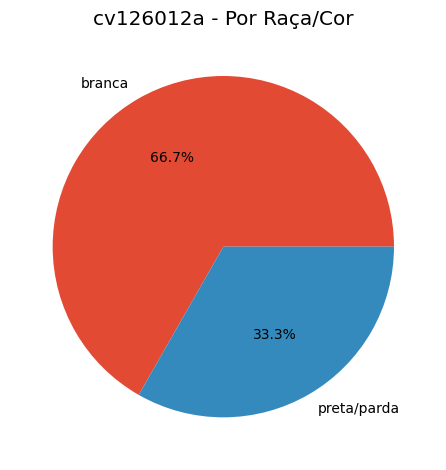


📊 Gerando gráficos para: cv126013a


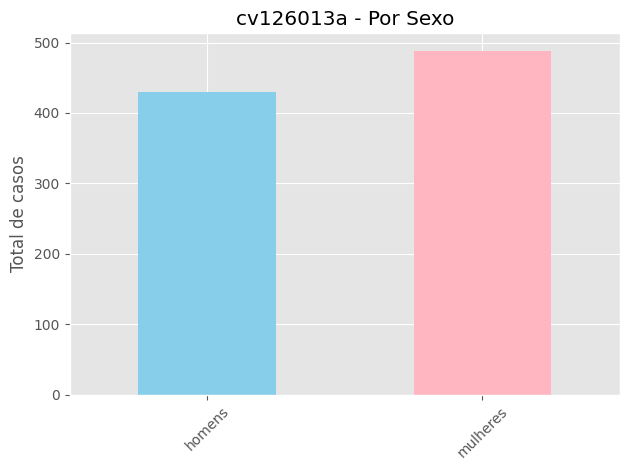

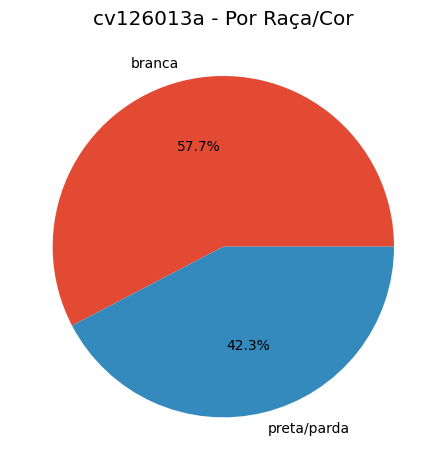


📊 Gerando gráficos para: cv126021a


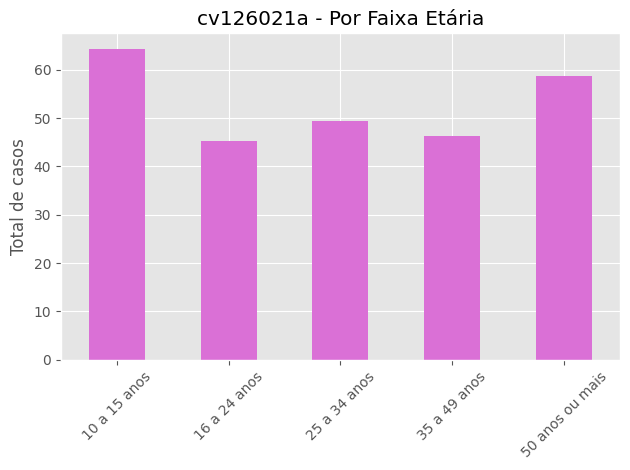


📊 Gerando gráficos para: cv126022a


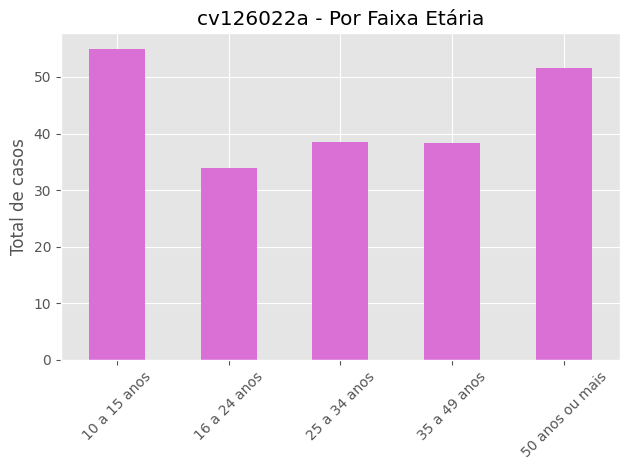


📊 Gerando gráficos para: cv126023a


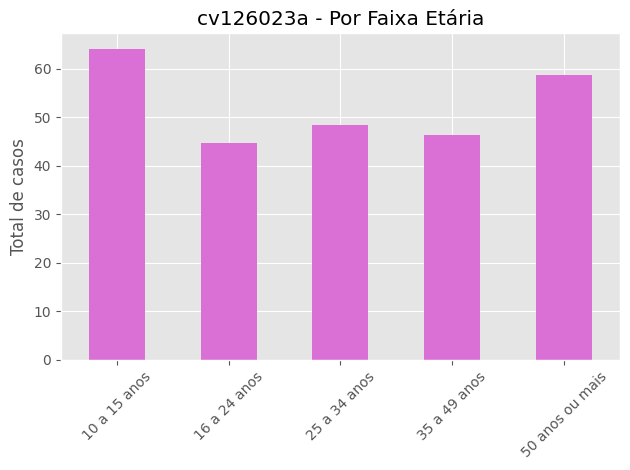


📊 Gerando gráficos para: cv126031a

📊 Gerando gráficos para: cv126032a

📊 Gerando gráficos para: cv126033a

📊 Gerando gráficos para: cv126041a

📊 Gerando gráficos para: cv126042a

📊 Gerando gráficos para: cv126051a

📊 Gerando gráficos para: cv126052a

📊 Gerando gráficos para: cv126061a

📊 Gerando gráficos para: cv126062a

📊 Gerando gráficos para: cv126071a

📊 Gerando gráficos para: cv126072a

📊 Gerando gráficos para: cv126081a

📊 Gerando gráficos para: cv126082a

📊 Gerando gráficos para: cv126091a

📊 Gerando gráficos para: cv126092a

📊 Gerando gráficos para: cv126101a

📊 Gerando gráficos para: cv126102a


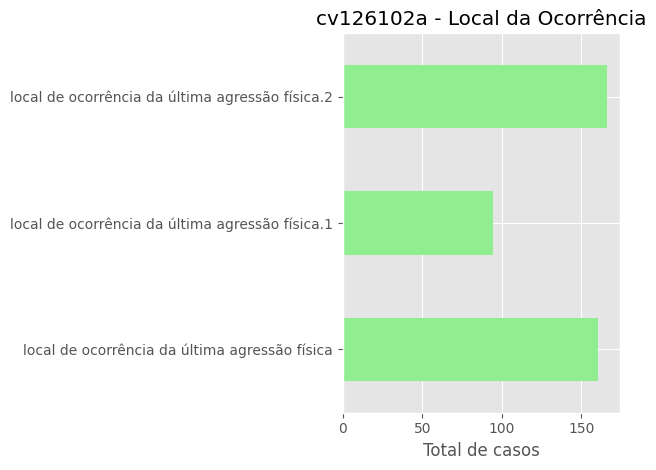


📊 Gerando gráficos para: cv126111a

📊 Gerando gráficos para: cv126112a

📊 Gerando gráficos para: cv126121a

📊 Gerando gráficos para: cv126122a

📊 Gerando gráficos para: cv126131a

📊 Gerando gráficos para: cv126132a

📊 Gerando gráficos para: cv126133a

📊 Gerando gráficos para: cv126141a

📊 Gerando gráficos para: cv126142a

📊 Gerando gráficos para: cv126143a

📊 Gerando gráficos para: cv126151a

📊 Gerando gráficos para: cv126152a

📊 Gerando gráficos para: cv126153a

📊 Gerando gráficos para: cv126161a

📊 Gerando gráficos para: cv126162a

📊 Gerando gráficos para: cv126163a

📊 Gerando gráficos para: cv126171a_tab 1.2.6.17.1 

📊 Gerando gráficos para: cv126171a_tab 1.2.6.17.2

📊 Gerando gráficos para: cv126171a_tab 1.2.6.18.1

📊 Gerando gráficos para: cv126171a_tab 1.2.6.18.2

📊 Gerando gráficos para: cv126171a_tab 1.2.6.19.1 

📊 Gerando gráficos para: cv126171a_tab 1.2.6.19.2

📊 Gerando gráficos para: cv126171a_tab 1.2.6.20.1

📊 Gerando gráficos para: cv126171a_tab 1.2.6.20.2

📊 Gerando grá

In [ ]:
def plotar_graficos_agressao(dados_agressao):
    for nome_df, df in dados_agressao.items():
        print(f"\n📊 Gerando gráficos para: {nome_df}")
        
        # Remove multiindex para facilitar, se necessário

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [' '.join(col).strip() for col in df.columns.values]


        # --- Gráfico 1: Comparação por Sexo ---
        colunas_sexo = [col for col in df.columns if 'homens' in col or 'mulheres' in col]
        if colunas_sexo:
            df_sexo = df[colunas_sexo].sum()
            df_sexo.plot(kind='bar', color=['skyblue', 'lightpink'], title=f"{nome_df} - Por Sexo")
            plt.ylabel('Total de casos')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # --- Gráfico 2: Distribuição por Cor/Raça ---
        colunas_raca = [col for col in df.columns if any(r in col.lower() for r in ['branca', 'preta', 'parda', 'preta/parda'])]
        if colunas_raca:
            df_raca = df[colunas_raca].sum()
            df_raca.plot(kind='pie', autopct='%1.1f%%', title=f"{nome_df} - Por Raça/Cor")
            plt.ylabel('')
            plt.tight_layout()
            plt.show()

        # --- Gráfico 3: Faixa Etária ---
        colunas_idade = [col for col in df.columns if 'anos' in col or 'idade' in col.lower()]
        if colunas_idade:
            df_idade = df[colunas_idade].sum()
            df_idade.plot(kind='bar', title=f"{nome_df} - Por Faixa Etária", color='orchid')
            plt.ylabel('Total de casos')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # --- Gráfico 4: Local de Ocorrência ---
        colunas_local = [col for col in df.columns if 'local' in col.lower()]
        if colunas_local:
            df_local = df[colunas_local].sum()
            df_local.plot(kind='barh', title=f"{nome_df} - Local da Ocorrência", color='lightgreen')
            plt.xlabel('Total de casos')
            plt.tight_layout()
            plt.show()

# Chame a função com os dados de agressão carregados anteriormente
plotar_graficos_agressao(dados["agressao"]['cv126011a'])

In [16]:
def plotar_graficos_com_contexto(dados_carregados, nome_arquivo_pdf="relatorio_final.pdf"):
    """
    Gera um PDF de gráficos. Para cada tabela, identifica os grupos no cabeçalho
    (ex: 'sexo', 'cor ou raça') e cria um gráfico para cada grupo.
    """
    with PdfPages(nome_arquivo_pdf) as pdf:
        for nome_df, info in dados_carregados.items():
            
            df = info['dataframe']
            titulo_principal = info['titulo']

            if not isinstance(df.columns, pd.MultiIndex):
                continue

            print(f"\n📊 Processando tabela: {titulo_principal}")

            # Identifica os grupos únicos no primeiro nível do cabeçalho
            grupos_cabecalho = df.columns.get_level_values(0).unique()
            
            # Cria uma figura com um subplot para cada grupo encontrado
            num_grupos = len(grupos_cabecalho)
            if num_grupos == 0: continue

            fig, axes = plt.subplots(nrows=num_grupos, ncols=1, figsize=(10, 6 * num_grupos), squeeze=False)
            axes = axes.flatten() # Garante que 'axes' seja sempre uma lista iterável

            fig.suptitle(titulo_principal, fontsize=14, y=0.99, wrap=True)

            # Itera sobre cada grupo do cabeçalho (ex: 'sexo', 'cor ou raça')
            for i, grupo in enumerate(grupos_cabecalho):
                ax = axes[i]
                
                # Seleciona as colunas pertencentes a este grupo
                df_grupo = df[grupo]
                
                print(f"  -> Gerando gráfico para o grupo: '{grupo}'")
                
                df_grupo.plot(kind='bar', ax=ax, width=0.8)
                
                ax.set_title(f"Análise por: {grupo.strip()}", fontsize=12)
                ax.set_ylabel('Valores')
                ax.tick_params(axis='x', rotation=45, labelsize=9)
                ax.legend(title=df_grupo.columns.name) # Usa o nome do nível inferior como título da legenda

            plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta para dar espaço ao título principal
            pdf.savefig(fig)
            plt.close(fig)

    print(f"\n✅ Relatório finalizado! O arquivo '{nome_arquivo_pdf}' foi salvo.")


# --- Execução ---


plotar_graficos_com_contexto(dados)


KeyError: 'dataframe'

In [ ]:
# ===================================================================
# CÉLULA 2: GERAÇÃO DO RELATÓRIO PDF FINAL
# ===================================================================

print("Iniciando a montagem do relatório em PDF...")

# Classe PDF personalizada com funções de ajuda
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        data_hoje = pd.to_datetime('today').strftime('%d de %B de %Y')
        self.cell(0, 10, f'Relatório PNAD 2009 - {data_hoje}', 0, 1, 'C')
        self.ln(5)
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Página {self.page_no()}', 0, 0, 'C')
    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)
    def output_df_to_pdf(self, df):
        # Header
        self.set_font('Arial', 'B', 10)
        col_width = self.w / (len(df.columns) + 1.5)
        for col in df.columns:
            self.cell(col_width, 10, str(col).replace('_', ' ').title(), 1, 0, 'C')
        self.ln()
        # Body
        self.set_font('Arial', '', 10)
        for index, row in df.iterrows():
            for col in df.columns:
                value = row[col]
                if isinstance(value, float):
                    value = f'{value:.2f}'
                self.cell(col_width, 10, str(value), 1, 0, 'C')
            self.ln()
        self.ln(5)

# Iniciar PDF
pdf = PDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(0, 10, 'Análise Combinada de Percepção de Segurança', 0, 1, 'C')
pdf.ln(10)

# Página 1: Risco por Sexo
pdf.chapter_title('1. Análise da Percepção de Risco por Sexo')
pdf.output_df_to_pdf(df_risco_sexo.set_index('sexo'))
pdf.image(caminho_grafico_sexo, w=170)

# Página 2: Risco por Bairro
pdf.add_page()
pdf.chapter_title('2. Análise da Percepção de Risco por Bairro')
pdf.output_df_to_pdf(df_risco_bairro.set_index('estrato_bairro'))
pdf.image(caminho_grafico_bairro, w=170)

# Página 3: Risco por Faixa de Idade
pdf.add_page()
pdf.chapter_title('3. Análise da Percepção de Risco por Faixa de Idade')
pdf.output_df_to_pdf(df_risco_idade.set_index('faixa_idade'))
pdf.image(caminho_grafico_idade, w=170)

# Página 4: Matriz de Correlação
pdf.add_page()
pdf.chapter_title('4. Matriz Numérica de Correlação entre Riscos')
pdf.set_font('Arial', '', 11)
pdf.multi_cell(0, 7, "A tabela e o mapa de calor abaixo mostram a correlação entre a percepção dos diferentes tipos de risco. Valores próximos de 1 indicam uma forte correlação positiva, significando que quem teme um tipo de crime também tende a temer o outro.")
pdf.ln(5)
pdf.image(caminho_grafico_correlacao, w=120, x=pdf.w / 2 - 60)

# Página 5: Conclusões
pdf.add_page()
pdf.chapter_title('5. Resultados e Conclusões')
texto_conclusao = (
    "A análise dos dados de percepção de segurança revela insights importantes sobre como diferentes "
    "grupos demográficos e sociais experienciam o medo em relação à criminalidade. A correlação positiva "
    "entre os tipos de risco sugere que a sensação de insegurança é um sentimento generalizado, não focado em um único tipo de crime.\n\n"
    "Observou-se que a percepção de risco não é homogênea, apresentando variações significativas "
    "quando segmentada por sexo, faixa etária e estrato do bairro de residência. "
    "Por exemplo, a análise por sexo indicou [descreva aqui a principal diferença, ex: que o público feminino percebe maior risco de sequestro].\n\n"
    "Estes resultados sugerem a necessidade de políticas de segurança pública que sejam sensíveis a "
    "essas diferentes percepções, focando esforços em localidades e grupos que demonstram maior "
    "sensação de insegurança."
)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 7, texto_conclusao.encode('latin-1', 'replace').decode('latin-1'))


# --- Salvamento e Limpeza ---
pasta_analises = os.path.join('..', '..', 'analises')
if not os.path.exists(pasta_analises):
    os.makedirs(pasta_analises)
caminho_arquivo_pdf = os.path.join(pasta_analises, "relatorio_completo_percepcao_social.pdf")

try:
    pdf.output(caminho_arquivo_pdf)
    caminho_absoluto = os.path.abspath(caminho_arquivo_pdf)
    print(f"\nPDF gerado com sucesso!")
    print(f"O arquivo foi salvo em: {caminho_absoluto}")
except Exception as e:
    print(f"\nOcorreu um erro ao gerar o PDF: {e}")
finally:
    for caminho in nomes_graficos:
        os.remove(caminho)
    os.rmdir(pasta_temp)
    print("\nArquivos temporários removidos.")

Iniciando a montagem do relatório em PDF...

PDF gerado com sucesso!
O arquivo foi salvo em: c:\Users\pedro\OneDrive\Documentos\GitHub\Repositorio_pesquisas\analises_vitimizacao\analises\relatorio_completo_percepcao_social.pdf

Arquivos temporários removidos.
